## ¿Qué es un sistema RAG (Retrieval-Augmented Generation)?

RAG (Generación aumentada por recuperación) es una técnica que combina dos enfoques del procesamiento de lenguaje natural:

- **Recuperación de información (Retrieval):** busca fragmentos relevantes de una base de datos o documentos.
- **Generación de texto (Generation):** utiliza un modelo de lenguaje (LLM) para generar respuestas en lenguaje natural basadas en los fragmentos recuperados.

Esta arquitectura es útil cuando el modelo necesita responder preguntas sobre un conocimiento **externo**, que no necesariamente está en su entrenamiento.

### ¿Cómo funciona?

Aquí te dejamos una representación simplificada del flujo:


![img](img/rag.png)


### ¿Por qué usar RAG?

- El modelo no necesita memorizar todos los datos posibles.
- Se puede actualizar el conocimiento fácilmente cambiando la base documental.
- Mejora la precisión en tareas como **chatbots**, **QA (preguntas y respuestas)**, o **asistentes inteligentes** especializados.

En las siguientes celdas construiremos paso a paso un sistema RAG simple, comenzando por la indexación de un documento PDF y la creación del vectorstore para la etapa de recuperación.


### Construcción de un índice vectorial para un sistema RAG

En esta celda estamos realizando los primeros pasos esenciales para implementar un sistema RAG (Retrieval-Augmented Generation). Este tipo de sistema mejora la generación de respuestas al combinar modelos de lenguaje con fuentes externas de conocimiento, como documentos.

Aquí, seguimos el siguiente flujo:

1. **Carga de documentos**: Utilizamos `PyPDFLoader` para leer el contenido de un archivo PDF (en este caso, un paper académico). Esto nos proporciona los textos a partir de los cuales construiremos nuestra base de conocimiento.

2. **División del texto**: Con `RecursiveCharacterTextSplitter`, se divide el texto en fragmentos más pequeños (`chunks`) de longitud controlada. Esto es importante porque los modelos de lenguaje y los vectores de embedding tienen un límite de tokens por entrada. Usamos `chunk_size=500` y `chunk_overlap=50` para evitar pérdida de contexto entre fragmentos.

3. **Generación de embeddings**: Usamos el modelo `all-MiniLM-L6-v2` de HuggingFace para convertir cada fragmento de texto en un vector numérico (embedding). Estos vectores capturan el significado semántico del texto y permiten búsquedas por similitud.

4. **Construcción del almacén vectorial**: Finalmente, usamos `FAISS`, una librería eficiente para búsqueda de similitud entre vectores, para almacenar los embeddings generados. Este vectorstore será la base para recuperar fragmentos relevantes cuando el usuario haga una pregunta.

Con este índice vectorial ya listo, podremos implementar la parte de recuperación de información (`retrieval`) para ayudar al modelo generativo a responder preguntas con conocimiento externo.


In [1]:
from langchain.vectorstores import FAISS
from langchain.document_loaders import TextLoader, PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_huggingface.embeddings import HuggingFaceEmbeddings

In [2]:

# Load and split pdf
loader = PyPDFLoader("./data/1706.03762v7.pdf")
documents = loader.load()

text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = text_splitter.split_documents(documents)

# Embeddings
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Vectorstore
vectorstore = FAISS.from_documents(docs, embedding_model)


/Users/angelg.villanueva/Documents/04_DATA/041_DATASCIENCE_BOOTCAMP/DS102024_2/3-MachineLearning/7-DeepLearning/4-workshop-rag_chatbot/.venvRAG/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
docs = vectorstore.similarity_search ('give me the conclutions', k=2)
docs

[Document(id='f0140845-557c-4152-8964-5524e2b2c81d', metadata={'producer': 'pdfTeX-1.40.25', 'creator': 'LaTeX with hyperref', 'creationdate': '2024-04-10T21:11:43+00:00', 'author': '', 'keywords': '', 'moddate': '2024-04-10T21:11:43+00:00', 'ptex.fullbanner': 'This is pdfTeX, Version 3.141592653-2.6-1.40.25 (TeX Live 2023) kpathsea version 6.3.5', 'subject': '', 'title': '', 'trapped': '/False', 'source': './data/1706.03762v7.pdf', 'total_pages': 15, 'page': 12, 'page_label': '13'}, page_content='Attention Visualizations\nInput-Input Layer5\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\nIt\nis\nin\nthis\nspirit\nthat\na\nmajority\nof\nAmerican\ngovernments\nhave\npassed\nnew\nlaws\nsince\n2009\nmaking\nthe\nregistration\nor\nvoting\nprocess\nmore\ndifficult\n.\n<EOS>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad>\n<pad

In [4]:
vectorstore.save_local("faiss_vectorstore")

In [5]:
del vectorstore

## Cargando el modelo de lenguaje y creando un agente RAG con LangGraph

En esta sección completamos nuestro sistema RAG construyendo un **agente conversacional** que sigue dos pasos clave: **recuperación** y **generación**, ahora ya integrados en un flujo definido por nodos, gracias a `LangGraph`.

### ¿Qué estamos haciendo?

1. **Cargar el vectorstore:** Recuperamos el índice FAISS previamente guardado. Esto nos permite buscar documentos similares a una pregunta de usuario usando embeddings.

2. **Cargar el modelo de lenguaje:** Utilizamos el modelo `Phi-3-mini-4k-instruct` desde HuggingFace. Este modelo es eficiente y está afinado para tareas de instrucción como QA (pregunta-respuesta).




In [6]:
vectorstore = FAISS.load_local("faiss_vectorstore", embedding_model, allow_dangerous_deserialization=True)

In [7]:
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

# Modelo local desde Hugging Face
model_name = "microsoft/Phi-3-mini-4k-instruct"
llm = HuggingFaceEndpoint(
    repo_id=model_name,
    task="text-generation",
    max_new_tokens=512,
    do_sample=False,
    repetition_penalty=1.03,
)

chat_model = ChatHuggingFace(llm=llm)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


3. **Definir el estado del agente:** Usamos una clase `TypedDict` para estructurar lo que el agente conoce en cada momento: la pregunta del usuario (`query`), los documentos recuperados y la respuesta generada.

4. **Definir los pasos del agente:**
   - **retrieve:** Busca en el vectorstore los documentos más relevantes para la pregunta.
   - **generate:** Construye un *prompt* con el contexto recuperado y llama al modelo para generar una respuesta.

5. **Construcción del grafo:** Creamos un flujo secuencial con LangGraph, donde primero se recupera información y luego se genera la respuesta. Usamos `graph.compile()` para generar el agente final.

In [8]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, List
from langchain.schema import Document

# Estado del agente
class AgentState(TypedDict):
    query: str
    documents: List[Document]
    generation: str

# Paso retrieval
def retrieve(state):
    query = state["query"]
    docs = vectorstore.similarity_search(query, k=10)
    return {"documents": docs}

# Paso generación usando contexto
def generate(state):
    docs = state["documents"]
    query = state["query"]
    context = "\n\n".join(doc.page_content for doc in docs)

    prompt = f"""Contexto:\n{context}\n\nPregunta: {query}\nRespuesta breve:"""

    respuesta = chat_model.invoke(prompt)
    return {"generation": respuesta}

# Grafo del agente
graph = StateGraph(AgentState)
graph.add_node("retrieve", retrieve)
graph.add_node("generate", generate)
graph.set_entry_point("retrieve")
graph.add_edge("retrieve", "generate")
graph.add_edge("generate", END)

# Compilar
rag_agent = graph.compile()


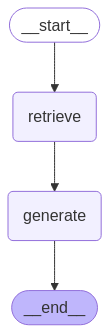

In [9]:
from IPython.display import Image, display

try:
    display(Image(rag_agent.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## Probando el agente RAG con una pregunta real

En esta celda realizamos una **ejecución completa** del sistema RAG con una pregunta de ejemplo. Esto incluye:

1. **Autenticación en Hugging Face**: Se solicita la API Key para acceder al modelo `Phi-3` desde Hugging Face. Esto permite usar el modelo de lenguaje sin necesidad de descargarlo localmente.


agv_aquí podemos tomar el token de .env, que es donde guardo mis secretos

In [13]:
from huggingface_hub import login
from dotenv import load_dotenv
load_dotenv()
login(os.getenv("HF_TOKEN"))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [15]:
import getpass
import os

os.environ["HUGGINGFACEHUB_API_TOKEN"] = getpass.getpass(
    "Enter your Hugging Face API key: "
)

2. **Definición de la pregunta**: Se plantea una consulta que queremos responder usando el contenido del documento previamente indexado.

3. **Invocación del agente**: Llamamos al agente RAG, quien sigue el flujo de recuperación → generación, y retorna una respuesta basada en el contexto recuperado.

4. **Visualización del resultado**: Finalmente, se imprime la respuesta generada por el modelo.

Este paso pone en acción todo lo construido hasta ahora. Puedes cambiar la pregunta y observar cómo se comporta el sistema con diferentes consultas.

In [14]:
pregunta = "Summarize the document"

respuesta = rag_agent.invoke({"query": pregunta})

print("Respuesta generada:\n")
print(respuesta["generation"])


Respuesta generada:

content="The document discusses the advancements in the field of natural language processing (NLP) focusing on Transformer models and their application to various tasks such as machine translation and abstractive summarization. It credits significant contributions from researchers and highlights the robust performance of NLP models in these application areas. Special attention is given to the development of attention-based models, particularly the Transformer, which have excelled in complex tasks like language modeling and reading comprehension when compared to traditional sequence-aligned recurrences.\n\nAttention mechanisms, especially Recurrent Attention Mechanisms, have shown great promise by achieving high performance in tasks requiring a deep understanding of language structure such as language modeling and solving simple language questions. End-to-end memory networks using these mechanisms have demonstrated effectiveness.\n\nThe focus then shifts to deep lea